In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats
import numpy as np

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
df = pd.read_csv("final_named_data.csv", index_col="id")
df.drop()

,Unnamed: 0,ccf,age,sex,painloc,painexer,relrest,pncaden,cp,trestbps,...,76,77,78,81,84,85,86,87,88,name
id,,,,,,,,,,,,,,,,,,,,,
1,0,15943882.0,63,1,NaN,NaN,NaN,NaN,1.0,145.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
2,1,15964847.0,67,1,NaN,NaN,NaN,NaN,4.0,160.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
3,2,15952199.0,67,1,NaN,NaN,NaN,NaN,4.0,120.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
4,3,15929464.0,37,1,NaN,NaN,NaN,NaN,3.0,130.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
6,4,11961207.0,41,0,NaN,NaN,NaN,NaN,2.0,130.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,1536,24309.0,47,0,1.0,NaN,NaN,NaN,2.0,110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Papp
1667,1537,22803.0,61,0,1.0,NaN,NaN,NaN,1.0,120.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friederi
1668,1538,13203.0,57,1,1.0,NaN,NaN,NaN,4.0,130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Torok


In [34]:
df.isnull().sum()

Unnamed: 0      0
ccf             6
age             0
sex             0
painloc       446
             ... 
85             51
86             51
87             51
88             51
name            0
Length: 83, dtype: int64

In [ ]:
columns_to_drop = ["Unnamed: 0", "id", "name"]
df_clean = df.drop(columns=columns_to_drop, errors="ignore")
df_clean = df_clean.loc[:, ~df_clean.columns.str.isnumeric()]
df_clean = df_clean.dropna(subset=["chol", "num"])

chol_stats = df_clean["chol"].describe()
chol_stats

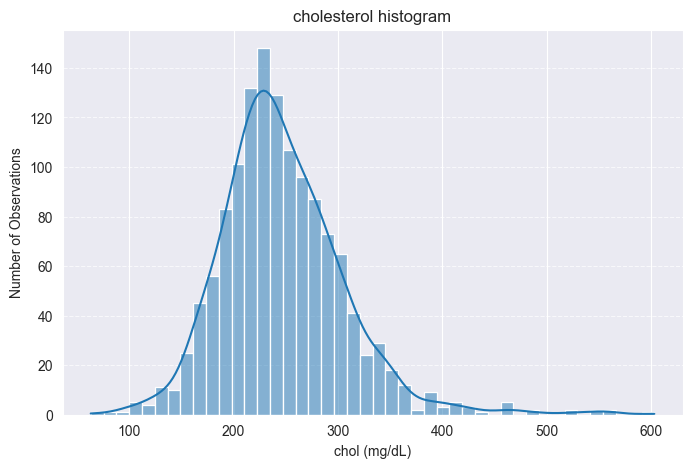

In [41]:
# Visualization of cholesterol histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["chol"], kde=True)
plt.xlabel("chol (mg/dL)")
plt.ylabel("Number of Observations")
plt.title("cholesterol histogram")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

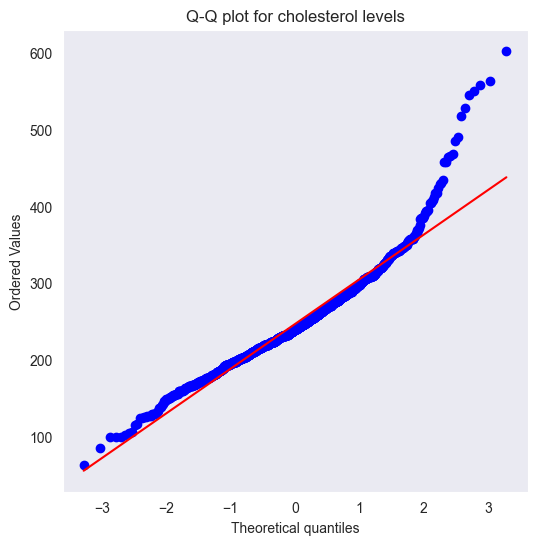

In [53]:
plt.figure(figsize=(6, 6))
stats.probplot(df_clean["chol"], dist="norm", plot=plt)
plt.title("Q-Q plot for cholesterol levels")
plt.grid()
plt.show()

In [58]:
shapiro_test = stats.shapiro(df_clean["chol"].sample(500, random_state=42))
# smaller sample bc test is sensitive to large data sets

print("Shapiro test statistic: ", shapiro_test[0])
print("p-value: ", shapiro_test[1])

Shapiro test statistic:  0.9787009882124806
p-value:  1.102837400930803e-06


In [ ]:
# Test Kolmogorov-Smirnov
ks_test = stats.kstest(
    df_clean["chol"], "norm", args=(df_clean["chol"].mean(), df_clean["chol"].std())
)
print("KS test statistic: ", ks_test[0])
print("p-value: ", ks_test[1])

KS test statistic:  0.06445231751787805
p-value:  2.754661533782824e-05


p-values są małe -> rozkład nie jest normalny, ale i tak zrobię test t-studenta, bo powinien być nieczuły na brak normalności przy takiej ilości danych, a potem powalcze z normalizacją


In [ ]:
chol_healthy = df_clean[df_clean["num"] == 0]["chol"]
chol_disease = df_clean[df_clean["num"] > 0]["chol"]

chol_means = {
    "Healthy (num=0)": round(chol_healthy.mean(), 2),
    "Disease (num>0)": round(chol_disease.mean(), 2),
}

print("cholesterol means:")
print("Healthy: ", chol_means["Healthy (num=0)"])
print("Disease: ", chol_means["Disease (num>0)"])

cholesterol means:
Healthy:  239.43
Disease:  253.63


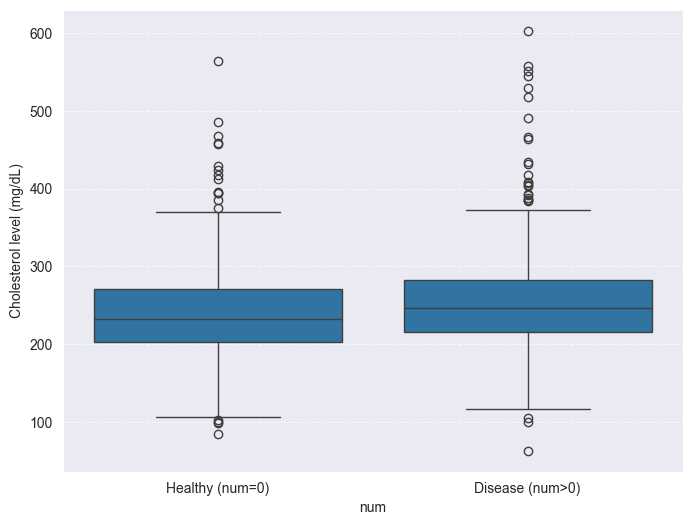

In [28]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_clean["num"] > 0, y=df_clean["chol"])
plt.xticks(ticks=[0, 1], labels=["Healthy (num=0)", "Disease (num>0)"])
plt.ylabel("Cholesterol level (mg/dL)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# Test t-Student
t_stat, p_value = ttest_ind(chol_healthy, chol_disease, equal_var=False)

print("t-test statistic: ", t_stat)
print("p-value: ", p_value)
print(
    "p-value less than 0.05 -> we can conclude that the average cholesterol level differs significantly between healthy and diseased individuals."
)

t-test statistic:  -4.372014523664578
p-value:  1.326599209760947e-05
p-value less than 0.05 -> we can conclude that the average cholesterol level differs significantly between healthy and diseased individuals.


In [ ]:
# Mann-Whitney test (Comparison of cholesterol means without normal distribution)
mann_whitney_test = stats.mannwhitneyu(
    chol_healthy, chol_disease, alternative="two-sided"
)

print("Mann Whitney test statistic: ", mann_whitney_test[0])
print("p-value: ", mann_whitney_test[1])

small p-value -> cholesterol level means differs significantly between healthy and diseased individuals


In [ ]:
df_clean["log_chol"] = np.log(df_clean["chol"] + 1)

shapiro_log_test = stats.shapiro(df_clean["log_chol"].sample(500, random_state=42))
ks_log_test = stats.kstest(
    df_clean["log_chol"],
    "norm",
    args=(df_clean["log_chol"].mean(), df_clean["log_chol"].std()),
)

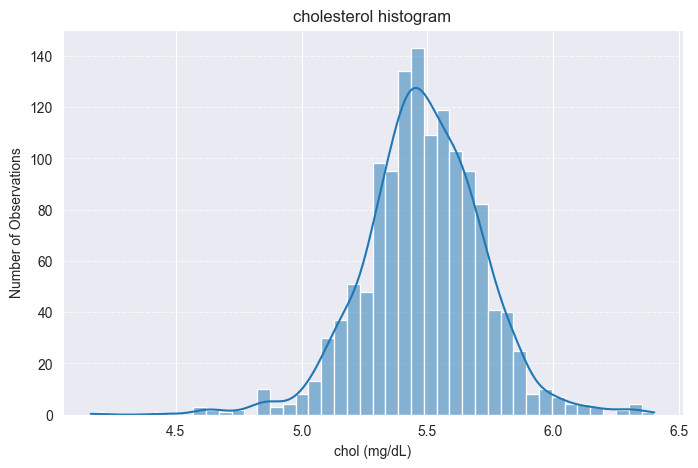

In [87]:
# Visualization of log transformation
plt.figure(figsize=(8, 5))
sns.histplot(df_clean["log_chol"], kde=True)
plt.xlabel("chol (mg/dL)")
plt.ylabel("Number of Observations")
plt.title("cholesterol histogram")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

nie podoba mi się do końca ten rozkład ale nie ma outlinerów, więc może i lepiej


In [85]:
print("KS test statistic: ", ks_log_test[0])
print("p-value: ", ks_log_test[1])

print("Shapiro test statistics: ", shapiro_log_test[0])
print("Shapiro test p-value: ", shapiro_log_test[1])

KS test statistic:  0.04003795899740026
p-value:  0.026417564469369936
Shapiro test statistics:  0.9804673350190238
Shapiro test p-value:  3.0126764038757855e-06


dalej nie jest to rozkład normalny ale ks ma wmiarę akceptowalną p-wartość, więc robie t-studenta z tej transformacji logarytmicznej


In [ ]:
# Test t-Studenta po transformacji
t_stat_log, p_value_log = stats.ttest_ind(
    df_clean[df_clean["num"] == 0]["log_chol"],
    df_clean[df_clean["num"] > 0]["log_chol"],
    equal_var=False,
)
print("t-test statistic: ", t_stat_log)
print("p-value: ", p_value_log)

t-test statistic:  -4.5563915096505845
p-value:  5.687809824629537e-06


wychodzi na to że mozna uznac cholesterol za istotny


In [ ]:
df_clean[df_clean["chol"] > 450]["chol"]

id
167     564.00
1282    468.00
1284    518.00
1202    529.00
1229    466.00
1143    603.00
1014    491.00
1445    464.40
1576    551.00
1921    458.15
1951    558.25
1968    485.10
2081    458.00
2548    545.00
Name: chol, dtype: float64